In [2]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt
from tensorflow import keras

In [3]:
audio_files = glob.glob("./ravdess-emotional-speech-audio/versions/1/*/*")
print(audio_files)

['./ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-04-01-01-02-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-06-01-01-02-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-04-02-02-01-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-08-01-02-02-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-03-01-02-02-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-04-01-02-01-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-02-01-02-01-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-07-01-02-01-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-04-02-01-02-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-05-02-01-01-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-05-01-02-01-09.wav', './ravdess-emotional-speech-audio/versions/1/Actor_09/03-01-08-01-02-01-09.wav', './ravdess-emotional-speech

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

So we have to make the outputs for each audio, it means we have to select only the emotion for each audio.

In [4]:
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
Y = []
# We will iterate in a copy of audio_files to delete all the non-audio files
for audio in audio_files[:]:
    if not audio.endswith("wav"):
        audio_files.remove(audio)
    else:
        Y.append(int(audio.split("-")[-5]) -1)

Y = np.array(Y)

print(len(audio_files))
print(Y)

1440
[3 5 3 ... 1 4 5]


Preparing my inputs data

In [ ]:
def prepare_data(audio_files):
    X = []
    length = []
    for audio in audio_files:
        audio_file, m = librosa.load(audio, sr=22050)
        # We delete empty sound from begining and ending
        audio_file , _ = librosa.effects.trim(audio_file, top_db=40)

        # We make sure our sound is 3 seconds before applying all the other functions on it
        audio_file = librosa.util.fix_length(audio_file, size=3*22050)
        y = librosa.get_duration(path=audio)
        
        # We apply short time fourier transform
        audio_file_transformed = librosa.stft(audio_file)
        # We make the spectogram
        spectogram = np.abs(audio_file_transformed)
        spectogram_db = librosa.amplitude_to_db(spectogram)
        X.append(spectogram_db)
    
    return np.stack(X)

X = prepare_data(audio_files)

77988
51712


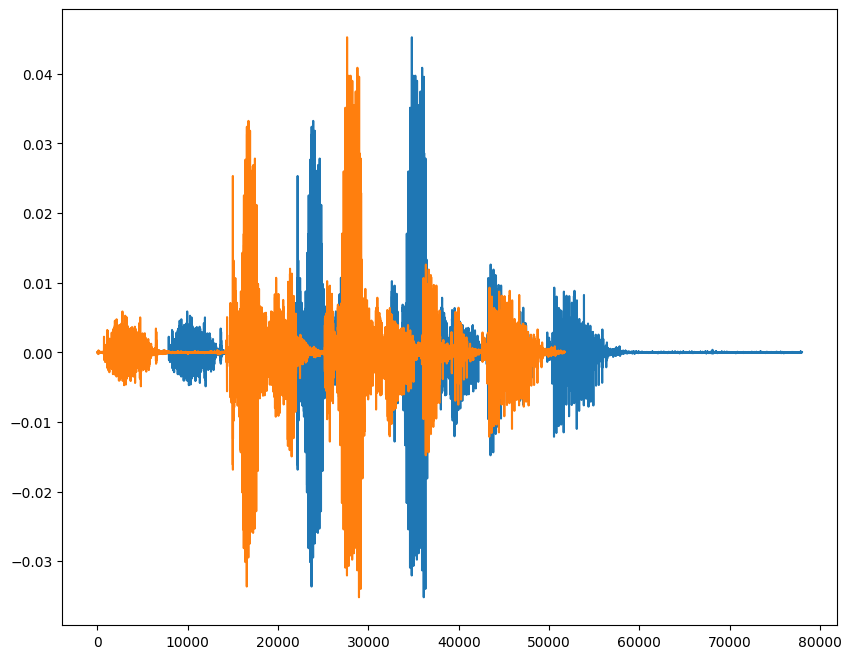

In [42]:
audio_file, m = librosa.load(audio_files[30], sr=22050)
print(len(audio_file))
audio_file1 , _ = librosa.effects.trim(audio_file, top_db=40)
print(len(audio_file1))

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(audio_file)
plt.plot(audio_file1)
plt.show()

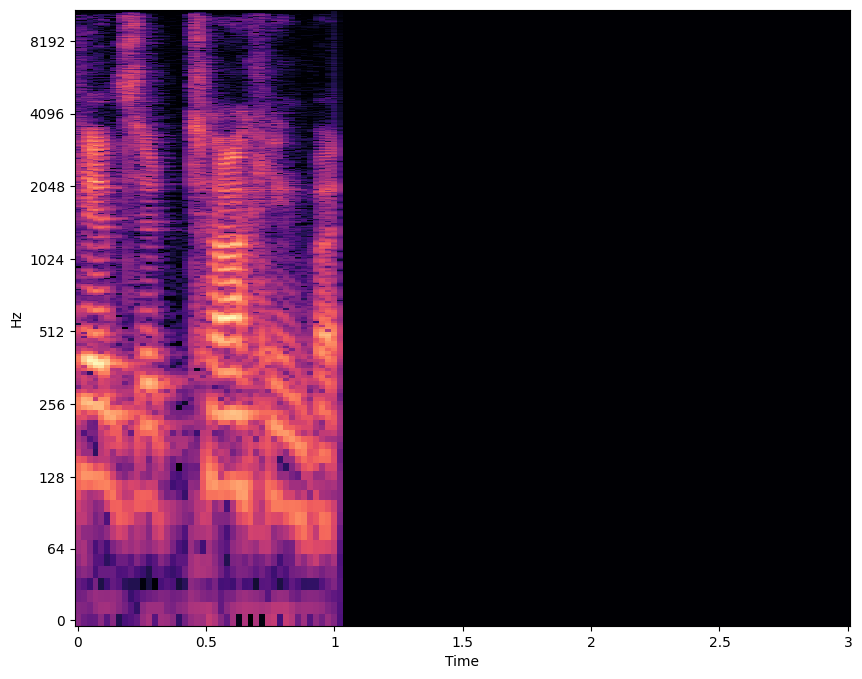

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
librosa.display.specshow(X[30], x_axis="time", y_axis="log", ax=ax)

Creating Model

In [ ]:
input = keras.Input(shape=X.shape[1:])
reshape = keras.layers.Reshape(X.shape[1:] + (1,))(input)

cnn = keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1))(reshape)
avr = keras.layers.AveragePooling2D(pool_size=(5,5), strides=(2,2))(cnn)
normalization = keras.layers.BatchNormalization()(avr)

cnn = keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1))(normalization)
avr = keras.layers.AveragePooling2D(pool_size=(5,5), strides=(2,2))(cnn)
normalization = keras.layers.BatchNormalization()(avr)

cnn = keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1))(normalization)
avr = keras.layers.AveragePooling2D(pool_size=(5,5), strides=(2,2))(cnn)
normalization = keras.layers.BatchNormalization()(avr)

flatten = keras.layers.Flatten()(normalization)
layer = keras.layers.Dense(32, activation="relu")(flatten)
output = keras.layers.Dense(8, activation="softmax")(layer)

model = keras.Model(inputs=input, outputs=output)
model.summary()

In [ ]:
train_size = int(0.8*len(X))

X_train = X[:train_size]
Y_train = Y[:train_size]

X_test = X[train_size:]
Y_test = Y[train_size:]

In [ ]:

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

checkpoint = keras.callbacks.ModelCheckpoint(filepath="model.keras", monitor="val_accuracy", mode="max")

In [ ]:
np.max(Y)

In [ ]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=50, callbacks=checkpoint, validation_split=0.2)

test_scores = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])